In [1]:
import warnings
warnings.filterwarnings('ignore')
from utils import *
from network import *

In [2]:
def find_username(fpath,splitter = '-'):
    i = fpath.rfind('/')
    return fpath[i+1:fpath.find(splitter, i)]

In [3]:
#!/usr/bin/env python3
checkpoints = os.listdir(get_rel_path('checkpoints/'))
checkpoints.sort()
print('Checkpoint Loaded:',checkpoints[-1])
model, *_ = load_saved_model(checkpoints[-1]) #MODEL_FNAME

def fwd_pass(user_stfts, model=model):
    """
    recordings is the result of split recordings
    returns mean embedding of recordings
    """

    user_stfts = torch.tensor(user_stfts).to(device)
#     print('user_stfts.shape:', user_stfts.shape)  ##let's check the shapes
    out = model.forward_single(user_stfts)
    out_np = out.detach().cpu().numpy()

    return np.expand_dims(np.mean(out_np, axis=0), axis=0)


def get_emb( enroll = False, file = ''):#fpath
#     record(fpath, enroll)
    if file:
        data , _ = librosa.load(file,sr=RATE)
        NOISE_DURATION_FROM_FILE = int(len(data)*0.25)
        NOISE_DURATION_FROM_FILE = min(NOISE_DURATION_FROM_FILE, RATE*2)
        noise = data[:NOISE_DURATION_FROM_FILE]
        data = data[NOISE_DURATION_FROM_FILE:]
        denoised_data = removeNoise(data,noise).astype('float32')
    else:
        denoised_data = record_and_denoise( enroll)
#     user_stfts = split_recording(fpath)
    user_stfts = split_loaded_data(denoised_data, RATE)
    user_stfts = np.expand_dims(user_stfts, axis=1)
#     print(user_stfts.shape)
    emb = fwd_pass(user_stfts)
#     print('emb shape:', emb.shape) #Let's check shape
    return emb#, denoised_data  #audio_buffer, bg_buffer 


def emb_dist(emb1, emb2):
    return 1 - scipy.spatial.distance.cdist(emb1, emb2, DISTANCE_METRIC).item()


Checkpoint Loaded: checkpoint_20200617-223848_0.00133806886151433.pth.tar


In [4]:
fpaths = []
# recording_data = []
file_name = []
user_name = []
with open('datasets/omic_list.txt', 'r') as f:
    for line in f:
        fpaths.append(line.rsplit('\n')[0])
#         data, _ = librosa.load(line.rsplit('\n')[0], sr=RATE)
#         recording_data.append(data)
        file_name.append(find_username(line,splitter = '.'))
        user_name.append(find_username(line,splitter = '_'))

In [5]:
df = pd.DataFrame({'fpath':fpaths,'user':user_name, 'file' : file_name})

In [6]:
tqdm.pandas()
df['data'] = df['fpath'].progress_apply(lambda x:get_emb(file = x))

100%|██████████| 127/127 [01:50<00:00,  1.15it/s]


In [7]:
user_label = {}
i = 0
for user in df['user']:
    if user not in user_label:
        user_label[user] = i
        i+=1

In [8]:
user_label

{'luke': 0, 'Meghan': 1, 'caio': 2, 'Ben': 3, 'Gabe': 4}

In [9]:
df['user_i'] = df['user'].apply(lambda x: user_label[x])

In [10]:
%matplotlib inline
def plot_tsne(data, user_i, user_list):
    tsne = TSNE(n_components=2, perplexity=25, init='pca', random_state=2444, method='exact')
    tsne_embedding = tsne.fit_transform(data)
    plt.figure(figsize=(10, 6))
    plt.scatter(x=tsne_embedding[:,0], y=tsne_embedding[:, 1], c=user_i, cmap='jet', alpha=0.5)
    plt.tight_layout()
    plt.title('Learned Embeddings for Training Users')
#     fname = "training_users_embeddings_" + time.strftime("%Y%m%d-%H%M%S")
#     plt.legend(user_list)
#     plt.savefig(fname)
    plt.show()
#     return tsne_embedding

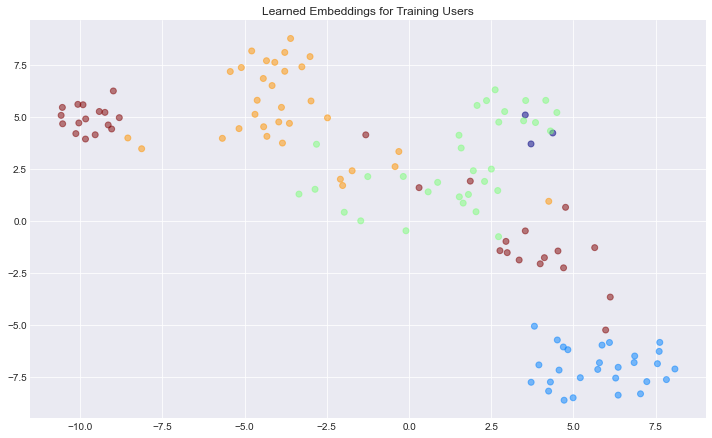

In [11]:
plot_tsne(np.vstack(df['data']),df['user_i'].to_list(),list(user_label.keys()))

In [12]:
# df['data'] = df['data'].apply(lambda x: np.array(x,dtype = 'float'))

In [13]:
tsne = TSNE(n_components=2, perplexity=25, init='pca', random_state=2444, method='exact')
tsne_embedding = tsne.fit_transform(np.vstack(df['data']))

<Figure size 720x432 with 0 Axes>

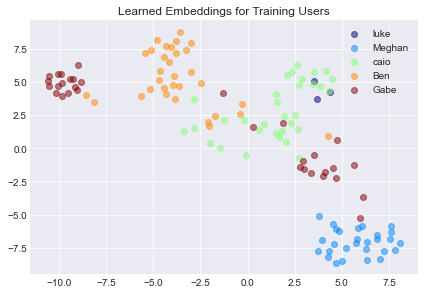

In [14]:
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
for user in user_label:
    ax.scatter(x=tsne_embedding[df['user_i']==user_label[user],0]\
               , y=tsne_embedding[df['user_i']==user_label[user], 1]\
               , c=[plt.get_cmap('jet')(user_label[user]*65)], alpha=0.5, label = user)
plt.tight_layout()
plt.title('Learned Embeddings for Training Users')
fname = "omic_users_embeddings_" + time.strftime("%Y%m%d-%H%M%S")
ax.legend()
# plt.savefig(fname)
plt.show()

In [15]:
df['user_env'] = df['file'].apply(lambda x: x.rsplit('_',1)[0])

In [16]:
df['user_env']

0        luke_1
1        luke_1
2        luke_1
3      Meghan_1
4      Meghan_3
         ...   
122      Gabe_1
123      Gabe_1
124      Gabe_1
125      Gabe_1
126      Gabe_1
Name: user_env, Length: 127, dtype: object

In [17]:
user_env_label = {}
i = 0
for u in df['user_env']:
    if u not in user_env_label:
        user_env_label[u] = i
        i+=1

In [18]:
df['user_env_i'] = df['user_env'].apply(lambda x: user_env_label[x])

<Figure size 720x432 with 0 Axes>

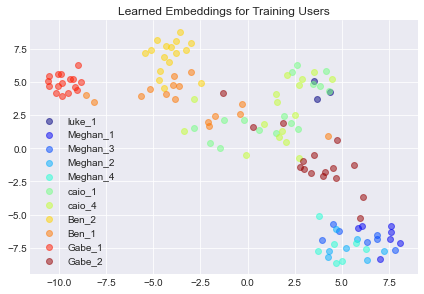

In [19]:
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
for user in user_env_label:
    ax.scatter(x=tsne_embedding[df['user_env_i']==user_env_label[user],0]\
               , y=tsne_embedding[df['user_env_i']==user_env_label[user], 1]\
               , c=[plt.get_cmap('jet')(user_env_label[user]*25)], alpha=0.5, label = user)
plt.tight_layout()
plt.title('Learned Embeddings for Training Users')
# fname = "omic_users_env_embeddings_" + time.strftime("%Y%m%d-%H%M%S")
ax.legend()
# plt.savefig(fname)
plt.show()

In [20]:
import seaborn as sns

In [21]:
df_by_user_env = pd.DataFrame(df.groupby('user_env').apply(lambda x:np.average(x['data'])),columns=['data'])

In [22]:
df_by_user_env

,data
user_env,
Ben_1,"[[-0.062371623, -0.000917223, -0.051415965, -0..."
Ben_2,"[[-0.06640274, -0.010352934, -0.053899154, -0...."
Gabe_1,"[[-0.0637333, 0.009097774, -0.048618395, -0.00..."
Gabe_2,"[[-0.064040214, -0.018099524, -0.055953655, -0..."
Meghan_1,"[[-0.06499279, -0.029724142, -0.058581144, -0...."
Meghan_2,"[[-0.06202329, -0.018887708, -0.05543888, -0.0..."
Meghan_3,"[[-0.06335149, -0.021729903, -0.056283124, -0...."
Meghan_4,"[[-0.061030805, -0.017025154, -0.05502493, -0...."
caio_1,"[[-0.057600923, -0.0034739224, -0.052778944, -..."


In [23]:
c_score = cosine_similarity(np.vstack(df_by_user_env['data']))

In [24]:
# c_dist_log = abs(np.log(1-cosine_similarity(np.vstack(df_by_user_env['data']))))

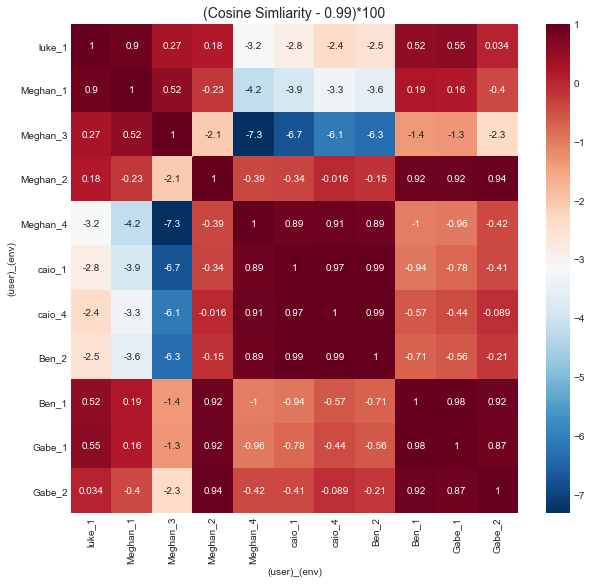

In [25]:
plt.figure(figsize=(10,9))
sns.heatmap((c_score-0.99)*100,cmap='RdBu_r',vmax=1,annot=True, xticklabels=list(user_env_label),yticklabels=list(user_env_label))
plt.title("(Cosine Simliarity - 0.99)*100",fontsize=14)
plt.xlabel("(user)_(env)")
plt.ylabel("(user)_(env)")
fname = "omic_users_heatmap" + time.strftime("%Y%m%d-%H%M%S")
plt.savefig(fname)
plt.show()